# Lab 1: Conditioning and Stability

In [2]:
import scipy.linalg as linalg
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.optimize as opt

## Problem 1:

In [2]:
def what_condition_my_condition_was_in(A):
    U, s, Vt = linalg.svd(A)
    if np.min(s) == 0:
        return np.inf
    cond = np.max(s)/np.min(s)
    return cond

In [5]:
A = np.array([[1,2],[3,4]])
print(what_condition_my_condition_was_in(A))
print(np.linalg.cond(A))

Q, R = linalg.qr(A)
print(what_condition_my_condition_was_in(Q))

B = np.zeros((3,3))
print(what_condition_my_condition_was_in(B))

14.933034373659265
14.933034373659268
1.0
inf


## Problem 2:

In [79]:
def experimentado(num_exp):
    avg_abs_norm = 0
    avg_rel_norm = 0
    for i in range(num_exp):
        r = np.random.normal(1,10**(-10), 21)
        orig_roots= np.arange(1,21)
        x, i = sy.symbols('x i')
        w = sy.poly_from_expr(sy.product(x-i, (i,1,20)))[0]
        w_coeffs = np.array(w.all_coeffs())
        w_coeffs *= r
        new_roots = np.roots(np.poly1d(w_coeffs))
        plt.scatter(np.real(orig_roots), np.imag(orig_roots), marker='o')
        plt.scatter(np.real(new_roots), np.imag(new_roots), marker='.', color='black')
        h = np.ones(21)*1.E-7
        avg_abs_norm += linalg.norm(new_roots - orig_roots,np.inf)/linalg.norm(h, np.inf)
        avg_rel_norm += avg_abs_norm * linalg.norm(w_coeffs,np.inf)/linalg.norm(orig_roots, np.inf)
    
    avg_abs_norm /= num_exp
    avg_rel_norm /= num_exp
    
    return avg_abs_norm, avg_rel_norm
        

205643259.17987922
7.15986458508652e+27
Big numbers!


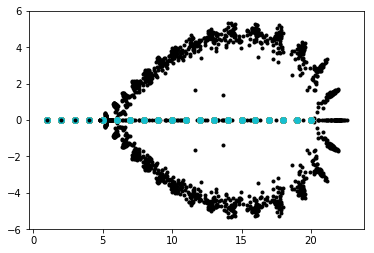

In [83]:
absol, rel = experimentado(100)
print(absol)
print(rel)
print("Big numbers!")

## Problem 3:

In [113]:
def condition_eigen(A):
    
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    eig_A = linalg.eigvals(A)

    eig_AH = linalg.eigvals(A+H)

    abs_norm = linalg.norm(eig_A - eig_AH, 2)/linalg.norm(H, 2)
    
    rel_norm = abs_norm * linalg.norm(A,2)/linalg.norm(eig_A,2)
    return abs_norm, rel_norm

In [115]:
A = np.random.random((10,10))
print(condition_eigen(A))


(1.2383776869110452, 1.1910306227620155)


## Problem 4:

In [122]:
def res_res(bounds, res):
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    cond_grid = np.zeros(((res,res)))
    for i in range(len(x)):
        for j in range(len(y)):
            A = np.array([[1,x[i]], [y[j], 1]])
            garbage, cond_grid[i,j] = condition_eigen(A)
            
    plt.pcolormesh(x,y, cond_grid, cmap='gray_r')
    

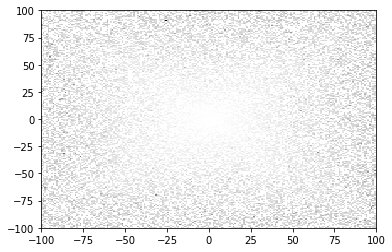

In [123]:
bounds = [-100, 100, -100, 100]
res = 200
res_res(bounds, res)

## Problem 5:

In [151]:
def least_squares(n):
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)
    
    x_inv = linalg.inv(A.T@A)@A.T @yk
    
    Q, R = linalg.qr(A, mode='economic')
    x_qr = linalg.solve_triangular(R, Q.T@yk)
    
    plt.plot(xk, np.polyval(x_inv, xk), label="normal equations")
    plt.plot(xk, np.polyval(x_qr, xk), label = "QR equations")
    plt.scatter(xk, yk, marker='*', color='black', lw=.01)
    plt.legend()
    
    inv_norm = np.sqrt(np.sum((np.polyval(x_inv, xk) - yk)**2))
    qr_norm = np.sqrt(np.sum((np.polyval(x_qr, xk) - yk)**2))
    return inv_norm, qr_norm

244.14511706592134 4.568370944341354


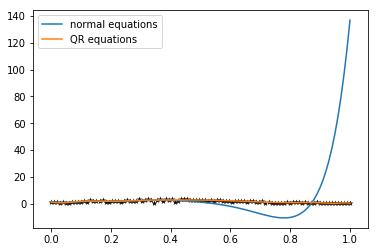

In [162]:
inv_norm, qr_norm = least_squares(14)
print(inv_norm, qr_norm)

## Problem 6:

In [189]:
import math

In [190]:
x = sy.symbols('x')
I_int = np.zeros(10)
icount = 0
for n in [5*k for k in range(1,11)]:
    n = int(n)
    I_int[icount] = float(sy.integrate(x**n * sy.exp(x-1), (x,0,1)))
    
    icount += 1


In [195]:
I_sums = np.zeros(10)
icount =0
rel_error = np.zeros(10)
for n in [5*k for k in range(1,11)]:
    n = int(n)
    I_sums[icount] = float((-1)**n * sy.subfactorial(n) + (-1)**(n+1)*sy.factorial(n)/math.e)
    rel_error[icount] = abs(I_sums[icount]-I_int[icount])/abs(I_int[icount])
    icount +=1 
    

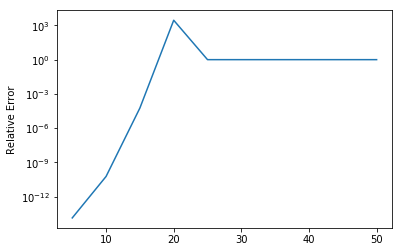

In [196]:
plt.plot(np.arange(5,51,5), rel_error)
plt.yscale('log')
plt.ylabel('Relative Error')
plt.show()

(10.6) looks like it has some non-trivial errors in approximating out integral, and is unstable, especially for larger n.

# Lab 2: Iterative Solvers

## Problem 1:

In [252]:
def Jacobi(A, b, tol, maxiters, plot=False):
    dist = 100
    iter_num = 0
    init_guess = b
    updated_guess = init_guess
    abs_err = []
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        
        D = np.diag(A)
        comp = updated_guess + (b - (A @ updated_guess))/D
        dist = linalg.norm(updated_guess - comp, np.inf)
        updated_guess = comp
        abs_err.append(linalg.norm((A@updated_guess) - b, np.inf))
    
    if plot == True:
        plt.plot(np.linspace(1, iter_num, iter_num), abs_err, lw=3)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title("Convergence of Jacobi Method")
        plt.semilogy()
        plt.show()
    return updated_guess

In [253]:
def diag_dom(n, num_entries=None):
    """Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
    n (int): The dimension of the system.
    num_entries (int): The number of nonzero values.
    Defaults to n^(3/2)-n.
    Returns:
    A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A


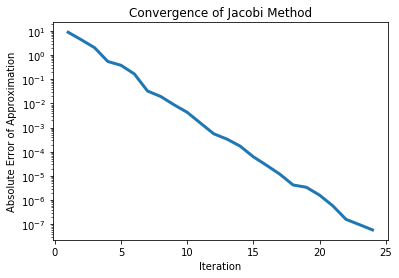

In [254]:
b = np.random.random(50)
A = diag_dom(50)
tol = 1.E-8
maxiters = 1000

xk = Jacobi(A, b, tol, maxiters, plot=True)

In [239]:
print('Error is: {}'.format(np.sum((A @xk) - b)))

Error is: 1.579761386913403e-07


## Problem 2:

See Jaccobi Function in problem 1

## Problem 3:

In [286]:
def gauss_seidel(A, b, tol, maxiters, plot=False):
    dist = 100
    iter_num = 0
    init_guess = b
    updated_guess = init_guess
    abs_err = []
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        comp = np.zeros(len(updated_guess))
        D = np.diag(A)
        for i in range(len(A[:,0])):
            comp[i] = updated_guess[i] + (1/D[i])*(b[i] - A[i]@updated_guess)
        dist = linalg.norm(updated_guess - comp, np.inf)
        updated_guess = comp
        abs_err.append(linalg.norm((A@updated_guess) - b, np.inf))
        
    if plot == True:
        plt.plot(np.linspace(1, iter_num, iter_num), abs_err, lw=3)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title("Convergence of Gauss-Seidel Method")
        plt.semilogy()
        plt.show()
    print(iter_num)
    if iter_num == 1001:
        print("convergence failed, exceeded maximum iterations")
    return updated_guess

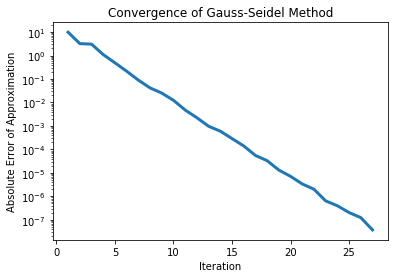

27


In [287]:
b = np.random.random(50)
A = diag_dom(50)
tol = 1e-8
maxiters = 1000

xk = gauss_seidel(A, b, tol, maxiters, plot=True)

## Problem 4:

In [294]:
def gauss_seidel_sparse(A, b, tol, maxiters):
    dist = 100
    iter_num = 0
    init_guess = b
    updated_guess = init_guess
    
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        comp = np.zeros(len(updated_guess))
        
        for i in range(len(b)):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ updated_guess[A.indices[rowstart:rowend]]
            comp[i] = updated_guess[i] + (1/A[i,i])*(b[i] - Aix)
        dist = linalg.norm(updated_guess - comp, np.inf)
        updated_guess = comp
    
    return updated_guess
  

In [304]:

A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

error = A @ gauss_seidel_sparse(A,b,tol, maxiters) - b
print("The Error using Gauss Seidel and sparse matrices is: {}".format(np.sum(error)))

The Error using sparse matrices is: 0.00018535863160408115


## Problem 5:

In [368]:
def SQR_sparse(A, b, omega, tol, maxiters, ret_iters=False):
    dist = 100
    iter_num = 0
    init_guess = b
    updated_guess = init_guess
    
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        comp = np.zeros(len(updated_guess))
        
        for i in range(len(b)):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ updated_guess[A.indices[rowstart:rowend]]
            comp[i] = updated_guess[i] + (omega/A[i,i])*(b[i] - Aix)
        dist = linalg.norm(updated_guess - comp, np.inf)
        updated_guess = comp
    if ret_iters:
        return updated_guess, iter_num
    return updated_guess

In [369]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

error = A @ SQR_sparse(A,b, 1.1, tol, maxiters) - b
print("The Error using SQR and sparse matrices is: {}".format(np.sum(error)))

The Error using SQR and sparse matrices is: 1.9579993228678594e-06


## Problem 6:

In [380]:
def finite_diff(n, omega, tol=1e-8, maxiters=1000, plot=False, ret_iters=False):
    t = np.array([-100])
    t= np.append(t, np.zeros(n-2))
    t = np.append(t, [-100])
    b = np.tile(t, n)
    
    
    B = -4* np.eye(n)
    for i in range(len(B[0])-1):
        B[i,i+1] = 1
        B[i+1,i] = 1
    A = np.zeros((n**2, n**2))
    ## :( this was not fun
    for j in range(0,(n-1)**2,n):
        A[j:j+n,j:j+n] = B
        A[j+n:j+2*n,j:j+n] = np.eye(n)
        A[j:j+n,j+n:j+2*n] = np.eye(n)
    A[-n:,-n:] = B
    A = sparse.csr_matrix(A)
    if ret_iters:
        u = SQR_sparse(A, b, omega, tol, maxiters, ret_iters=True)
    else: u = SQR_sparse(A, b, omega, tol, maxiters)

    
    if plot==True:
        u = np.reshape(u, (n,n))
        plt.pcolormesh(u, cmap="coolwarm")
    return u

The Value of u is: [[49.99999984 33.33333308 33.33333308 49.99999984]
 [66.66666641 49.99999959 49.99999959 66.66666641]
 [66.66666641 49.99999959 49.99999959 66.66666641]
 [49.99999984 33.33333308 33.33333308 49.99999984]]


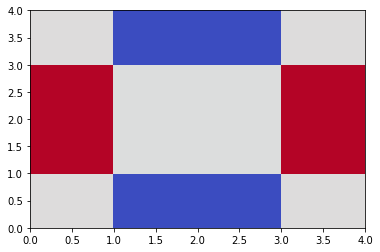

In [381]:
u = finite_diff(n, 1.01, plot=True)
print("The Value of u is: {}".format(u))

## Problem 7:

In [392]:
def best_omega():
    omeg_space = np.linspace(1,1.7, 20)
    iter_mat = np.zeros(20)
    icount = 0
    for omega in omeg_space:
        print(omega)
        u, iter_num = finite_diff(4, omega,tol=1e-2, maxiters=1000, ret_iters=True)
        iter_mat[icount] = iter_num
        icount +=1
    plt.plot(omeg_space, iter_mat)
    plt.xlabel('value of omega')
    plt.ylabel('iterations')
    return omeg_space[np.argmin(iter_mat)]

1.0
1.0368421052631578
1.0736842105263158
1.1105263157894736
1.1473684210526316
1.1842105263157894
1.2210526315789474
1.2578947368421052
1.2947368421052632
1.331578947368421
1.368421052631579
1.4052631578947368
1.4421052631578948
1.4789473684210526
1.5157894736842104
1.5526315789473684
1.5894736842105264
1.6263157894736842
1.663157894736842
1.7


1.2947368421052632

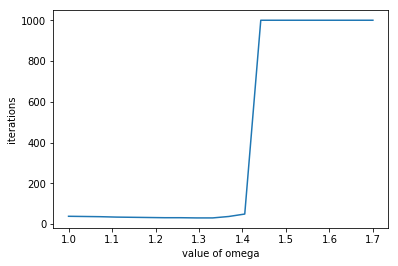

In [393]:
best_omega()

It seems that once omega gets past a threshold, the iterative solver fails. The best omega is 1.2947.

# Lab 3: Newton & Quasi-Newton Methods

## Problem 1:

In [476]:
def newtons_method(D, D2, x, tol=1e-8, maxiters=1000):
    converged = False
    dist = 100
    iter_num = 0
    init_guess = x
    updated_guess = init_guess
    
    while dist > tol and iter_num < maxiters:
        iter_num +=1
        Df = D(updated_guess)
        D2f = D2(updated_guess)
        
        zk = linalg.solve(D2f, Df)
        
        comp = updated_guess - zk
        
        dist = linalg.norm(Df, np.inf)
        updated_guess = comp
        
    if iter_num == 1000:
        print("convergence failed")
    else: converged = True
    return x, iter_num, converged

In [477]:
newtons_method(opt.rosen_der, opt.rosen_hess, np.array([-2, 2]))

(array([-2,  2]), 6, True)

## Problem 2:

In [478]:
def BFGS(D, x, maxiters=1000, tol=1e-8):
    converged = False
    n = len(x)
    dist = 100
    init_guess = x
    updated_guess = init_guess
    Ainv_guess = np.eye(n)
    updated_Ainv = Ainv_guess
    iter_num = 0
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        D_up = D(updated_guess)
        comp1 = updated_guess - updated_Ainv @ D_up.T

        yk = D(comp1).T - D_up.T
        
        sk = comp1 - updated_guess
        
        skyk = sk@yk
        
        if (skyk) == 0:
            print("Divide by zero. failed.")
            break
        term1 = np.outer(sk,sk)*((skyk + yk @ updated_Ainv @ yk))/(skyk)**2 
#         print("term1 = {}".format(term1))
        term2 = (updated_Ainv@np.outer(yk,sk) + (np.outer(sk,yk)@updated_Ainv))/skyk
#         print("term2 = {}".format(term2))

        comp2 = updated_Ainv + term1 - term2
        
        dist = linalg.norm(D(comp1), np.inf)
        updated_guess = comp1
        updated_Ainv = comp2
    if iter_num == 1000:
        print('convergence failed. max iterations reached.')
    else: converged = True
    return updated_guess, iter_num, converged
        
        

In [479]:
BFGS(opt.rosen_der, np.array([-2,2]))

(array([1., 1.]), 146, True)

## Problem 3:

In [480]:
import time
def test_methods(N):
    newt_time = np.zeros(N)
    newt_iters = np.zeros(N)
    BFGS_time = np.zeros(N)
    BFGS_iters = np.zeros(N)
    scipy_BF_time = np.zeros(N)
    scipy_BF_iters = np.zeros(N)
    for i in range(N):
        x0 = np.zeros(2)
        x0[0] = np.random.uniform(-3,3)
        x0[1] = np.random.uniform(-3,3)
        time_start_newt = time.time()
        _, newt_iters[i], _ = newtons_method(opt.rosen_der, opt.rosen_hess, x0)
        time_newt = time.time() - time_start_newt
        newt_time[i] = time_newt
        
        time_start_bfgs = time.time()
        _, BFGS_iters[i], _ = BFGS(opt.rosen_der, x0)
        time_bfgs = time.time() - time_start_bfgs
        BFGS_time[i] = time_bfgs
        
        time_start_scipy_BF = time.time()
        solution = opt.fmin_bfgs(opt.rosen, x0, fprime=opt.rosen_der, disp=False, retall=1)
        scipy_BF_iters[i] = len(solution[1]) ## solution is a 2D array containing all the iterations
        time_scipy_BF = time.time() - time_start_scipy_BF
        scipy_BF_time[i] = time_scipy_BF
        
    fig = plt.figure(figsize=(10,8))
    plt.loglog()
    plt.scatter(newt_time, newt_iters, alpha=.3, label="Newton's")
    
    plt.scatter(BFGS_time, BFGS_iters, alpha=.3, label="My BFGS")
    
    plt.scatter(scipy_BF_time, scipy_BF_iters, alpha=.3, label="Scipy's Feeble attempt at BFGS")
    plt.xlabel('Computational time')
    plt.ylabel('number of iterations')
    plt.legend()
    plt.show()
    
        
        

convergence failed. max iterations reached.
convergence failed. max iterations reached.
convergence failed. max iterations reached.
convergence failed. max iterations reached.


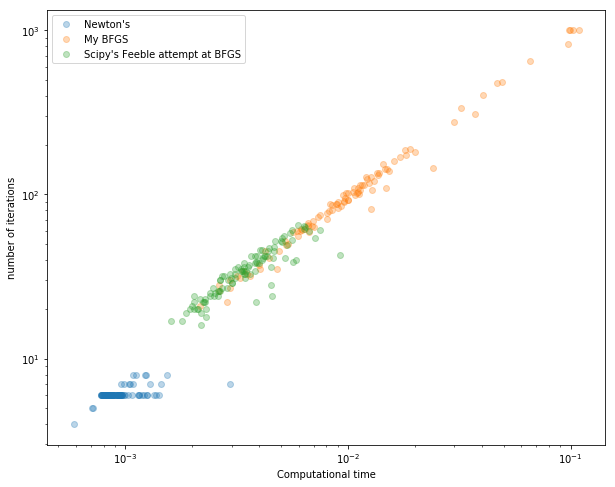

In [481]:
test_methods(100)

## Problem 4:

In [525]:
def gauss_newton(phi, res, Dr, x0, maxiters=1000, tol=1e-8):
    converged = False
    init_guess = x0
    updated_guess = x0
    dist = 100
    iter_num = 0
    while dist > tol and iter_num < maxiters:
        iter_num += 1
        J = Dr(updated_guess)
        
        D2f = J.T @ J
        comp = updated_guess - linalg.inv(D2f) @ J.T @ res(updated_guess)
        dist = linalg.norm(comp - updated_guess, np.inf)
        updated_guess = comp
    if iter_num != maxiters:
        converged = True
    return updated_guess, iter_num, converged

In [530]:
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))
x0 = np.array([2.5,.6])




In [531]:
gauss_newton(model, residual, jac, x0, maxiters=100, tol=1e-3)

(array([2.92307526, 0.49681816]), 3, True)

In [532]:
minx = opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
minx

(array([2.92307526, 0.49681816]), 1)

## Problem 5:

In [3]:
data = np.load('population.npy').T

In [4]:
dec_ind = data[0]
pop = data[1]

In [5]:
model2 = lambda x, t: x[0]*np.exp(x[1]*(t + x[2]))
resid2 = lambda x: model2(x, dec_ind) - pop
jac2 = lambda x: np.column_stack((np.exp(x[1]*(dec_ind + x[2])), \
                                        x[0]*np.exp(x[1]*(dec_ind + x[2]))*(dec_ind+x[2]), \
                                        x[0]*np.exp(x[1]*(dec_ind + x[2]))*x[1]))

minx2 = opt.leastsq(func = resid2, x0=[1.5, .4, 2.5], Dfun=jac2)
minx2

(array([8.80486911, 0.18474388, 0.14336178]), 1)

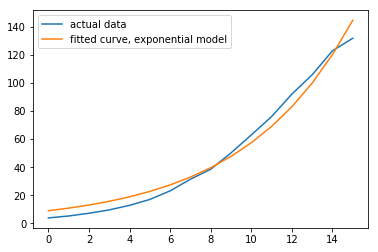

In [6]:
plt.plot(dec_ind, pop, label= 'actual data')
plt.plot(dec_ind, model2(minx2[0], dec_ind), label='fitted curve, exponential model')
plt.legend()
plt.show()

In [7]:
model3 = lambda x, t: x[0]/ (1 + np.exp(-x[1]*(t + x[2])))
resid3 = lambda x: model3(x, dec_ind) - pop
jac3 = lambda x: np.column_stack((1/(1 + np.exp(-x[1]*(dec_ind + x[2]))), \
                        x[0]*np.exp(-x[1]*(dec_ind + x[2]))*(dec_ind + x[2])/(1 + np.exp(-x[1]*(dec_ind + x[2])))**2,\
                        x[0]*np.exp(-x[1]*(dec_ind + x[2]))*x[1]/(1 + np.exp(-x[1]*(dec_ind + x[2])))**2 ))
minx3 = opt.leastsq(func = resid3, x0=[150, .4, -15], Dfun=jac3)
minx3

(array([184.76582414,   0.32169312, -12.05552938]), 1)

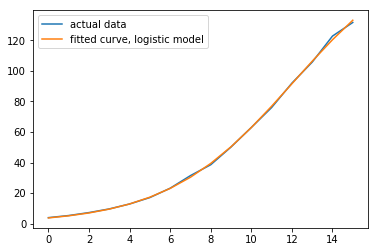

In [8]:
plt.plot(dec_ind, pop, label= 'actual data')
plt.plot(dec_ind, model3(minx3[0], dec_ind), label='fitted curve, logistic model')
plt.legend()
plt.show()

## Noice.